In [51]:
import pickle as pkl 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import utils
import models
import GraphKernel
from MKLpy.algorithms import AverageMKL, EasyMKL, KOMD, MEMO, PWMK, FHeuristic, CKA

In [52]:
path = 'data/'
with open(path + 'training_data.pkl', 'rb') as file: 
    train_graphs = pkl.load(file) 

with open(path + 'test_data.pkl', 'rb') as file: 
    test_graphs = pkl.load(file) 
    
with open(path + 'training_labels.pkl', 'rb') as file: 
    train_labels = pkl.load(file) 

In [53]:
for G in train_graphs:
    for e in G.nodes:
        G.nodes[e]['labels'] = [G.nodes[e]['labels'][0], 1]

for G in test_graphs:
    for e in G.nodes:
        G.nodes[e]['labels'] = [G.nodes[e]['labels'][0], 1]

for G in train_graphs:
    for e in G.edges:
        G.edges[e]['labels'] = G.edges[e]['labels'][0] + 1

for G in test_graphs:
    for e in G.edges:
        G.edges[e]['labels'] = G.edges[e]['labels'][0] + 1
        

In [54]:
import copy
def morgan_index(graphs):
    
    for (i,G) in enumerate(graphs):
        K = copy.deepcopy(G)
        for node in G.nodes:
            K.nodes[node]['labels'][1] = 0
            for x in G.neighbors(node):
                K.nodes[node]['labels'][1]  += G.nodes[x]['labels'][1]
        graphs[i] = K 

In [55]:
for i in range(1):
    morgan_index(train_graphs)
    morgan_index(test_graphs)

In [56]:
one_train = []
zero_train = []
for (i,G) in enumerate(train_graphs):
    if(train_labels[i] == 0):
        zero_train.append(G)
    else:
        one_train.append(G)    

In [57]:
n = 1000
train_graphs = one_train
train_labels = [1]*len(one_train)
for G in zero_train:
    if(len(train_graphs) == n):
        break
    train_graphs.append(G)
    train_labels.append(0)


In [58]:
zero_train = zero_train[n:]
y_zeros = np.zeros(len(zero_train))

In [59]:
len(zero_train)

0

In [60]:
#from grakel import ShortestPath
#gk = ShortestPath(with_labels=True)
#K_train = gk.fit_transform(train_graphs)

randomWalk = GraphKernel.WalkKernel(maxK = 100)  #GraphKernel.WalkKernel(maxK = 3) #GraphKernel.ShortestPath()#
shortestPath = GraphKernel.ShortestPath()
K_train = randomWalk.compute_kernel(train_graphs,train_graphs) + shortestPath.compute_kernel(train_graphs,train_graphs)
#K_train.append(K_1)

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(train_graphs, train_labels, test_size=0.3, random_state=100,stratify=train_labels)
#X_train_K = randomWalk.compute_kernel(X_train,X_train)# + shortestPath.compute_kernel(X_train,X_train)
#X_test_K = randomWalk.compute_kernel(X_test,X_train) #+ shortestPath.compute_kernel(X_test,X_train)
#K_zero = randomWalk.compute_kernel(zero_train,train_graphs) #+ shortestPath.compute_kernel(zero_train,train_graphs)


100%|██████████| 6000/6000 [42:56<00:00,  2.33it/s]  


In [61]:
K_train[np.isnan(K_train)] = 0

In [62]:
#from sklearn.svm import SVC
#clf = EasyMKL(learner=SVC(C = 1, kernel='precomputed',  probability=True, class_weight='balanced')).fit(K_train, train_labels)
#clf.solution.weights

In [63]:
#K_train_t = 0
#for i in range(len(clf.solution.weights)):
#    K_train_t+= K_train[i]*np.array(clf.solution.weights)[i]

In [64]:
C = 1

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from tqdm import tqdm

c = np.arange(0.1,1.5,0.1)
scores = []
for C in tqdm(c):
    for i in range(2):
        s = []
        skf = KFold(n_splits=5, random_state=i, shuffle=True)
        score = cross_val_score(SVC(C = C, kernel='precomputed',  probability=True, class_weight='balanced'), K_train, train_labels, cv=skf, scoring = 'roc_auc')
        s.append(score.reshape(-1))
    scores.append(np.mean(s))

C =  c[np.argsort(scores)[-1]]
print(scores)
print(C,np.sort(scores)[-1])

100%|██████████| 14/14 [02:32<00:00, 10.87s/it]

[0.9148923708693696, 0.9205409631623199, 0.9211183104040659, 0.9214928175374032, 0.921873554794049, 0.9218173957137962, 0.9211254082437454, 0.92095907124039, 0.9206278772781111, 0.9205736576664465, 0.920352571352263, 0.920143916517009, 0.9197528703370784, 0.9198265260461825]
0.5 0.921873554794049


In [83]:
print(C,np.sort(scores)[-1])

0.5 0.921873554794049


In [67]:
'''
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(K_train, train_labels)

if(K_zero.shape[0] > 0):
    # Predict and test.
    y_pred = clf.predict(K_zero)

    print("Classification accuracy: %0.2f" % accuracy_score(y_zeros, y_pred))
'''

'\nfrom sklearn.svm import SVC\nfrom sklearn.metrics import accuracy_score\nclf = SVC(C = C, kernel=\'precomputed\',  probability=True,class_weight=\'balanced\')\n\n# Fit on the train Kernel\nclf.fit(K_train, train_labels)\n\nif(K_zero.shape[0] > 0):\n    # Predict and test.\n    y_pred = clf.predict(K_zero)\n\n    print("Classification accuracy: %0.2f" % accuracy_score(y_zeros, y_pred))\n'

In [68]:
'''
from sklearn.metrics import confusion_matrix
from sklearn import metrics
if(K_zero.shape[0] > 0):
    y_pred = clf.predict(K_zero)
    #tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
    confusion_matrix = confusion_matrix(y_zeros, y_pred,normalize='true')
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()
'''

"\nfrom sklearn.metrics import confusion_matrix\nfrom sklearn import metrics\nif(K_zero.shape[0] > 0):\n    y_pred = clf.predict(K_zero)\n    #tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()\n    confusion_matrix = confusion_matrix(y_zeros, y_pred,normalize='true')\n    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])\n    cm_display.plot()\n    plt.show()\n"

In [69]:
'''
if(K_zero.shape[0] > 0):
    from sklearn.metrics import plot_roc_curve, auc 
    plot_roc_curve(clf, K_zero, y_zeros)
'''

'\nif(K_zero.shape[0] > 0):\n    from sklearn.metrics import plot_roc_curve, auc \n    plot_roc_curve(clf, K_zero, y_zeros)\n'

In [70]:
'''
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(X_train_K, y_train)

# Predict and test.
y_pred = clf.predict(X_test_K)

print("Classification accuracy: %0.2f" % accuracy_score(y_test, y_pred))
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, X_test_K, y_test)
'''

'\nfrom sklearn.svm import SVC\nfrom sklearn.metrics import accuracy_score\nclf = SVC(C = C, kernel=\'precomputed\',  probability=True,class_weight=\'balanced\')\n\n# Fit on the train Kernel\nclf.fit(X_train_K, y_train)\n\n# Predict and test.\ny_pred = clf.predict(X_test_K)\n\nprint("Classification accuracy: %0.2f" % accuracy_score(y_test, y_pred))\nfrom sklearn.metrics import plot_roc_curve, auc \nplot_roc_curve(clf, X_test_K, y_test)\n'

In [71]:
'''
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred = clf.predict(X_test_K)
#tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
confusion_matrix = confusion_matrix(y_test, y_pred,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
'''

"\nfrom sklearn.metrics import confusion_matrix\nfrom sklearn import metrics\ny_pred = clf.predict(X_test_K)\n#tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()\nconfusion_matrix = confusion_matrix(y_test, y_pred,normalize='true')\ncm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])\ncm_display.plot()\nplt.show()\n"

In [72]:
'''
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, X_test_K, y_test)
'''

'\nfrom sklearn.metrics import plot_roc_curve, auc \nplot_roc_curve(clf, X_test_K, y_test)\n'

In [73]:
K_test = randomWalk.compute_kernel(test_graphs,train_graphs) + shortestPath.compute_kernel(test_graphs,train_graphs) 

100%|██████████| 2000/2000 [23:27<00:00,  1.42it/s] 


In [74]:
y_train = train_labels
y_train = np.array(y_train).reshape(-1)

In [84]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(K_train, y_train)

# Predict and test.
y_pred = clf.predict(K_train)

print("Classification accuracy: %0.2f" % accuracy_score(y_train, y_pred))

Classification accuracy: 0.97


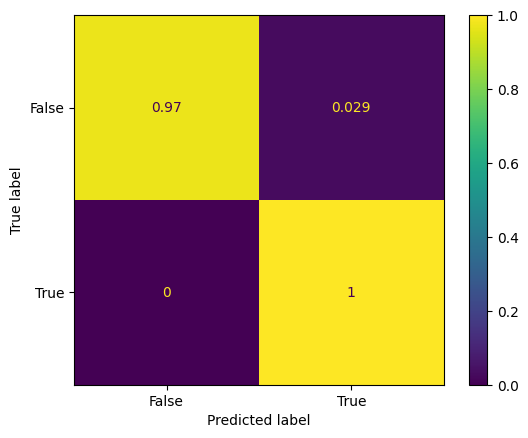

In [85]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred = clf.predict(K_train)
#tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
confusion_matrix = confusion_matrix(y_train, y_pred,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


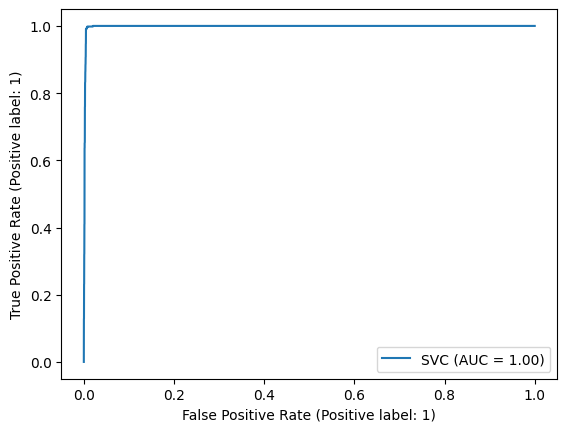

In [86]:
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, K_train, y_train)

In [87]:
y_pred = clf.predict_proba(K_test)[:,1]
y_pred = np.log(y_pred/(1-y_pred))
y_pred

array([-3.54272285, -1.76084809, -3.55866296, ..., -3.77969762,
        1.33086898, -3.84209781])

In [88]:
sub = pd.DataFrame()
sub['Id']= np.arange(1,len(y_pred)+1)
sub['Predicted'] = y_pred
sub.to_csv("submissions/sub.csv",index=False)

In [89]:
y_sub = pd.read_csv("submissions/sub.csv")
y_sub = np.array(y_sub['Predicted'])
y_sub[y_sub< 0 ] = 0
y_sub[y_sub>0] = 1
np.sum(y_sub)/len(y_sub)

0.104

In [90]:
y_sub = pd.read_csv("submissions/sub_089.csv")
y_sub = np.array(y_sub['Predicted'])
y_sub[y_sub< 0 ] = 0
y_sub[y_sub>0] = 1
np.sum(y_sub)/len(y_sub)

0.111